Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameterl(or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [505]:
%%capture
import sys
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [506]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [507]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [508]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

### Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'
#### and the sale price was more than 100 thousand and less than 2 million.

In [509]:
import category_encoders as ce
df = df[ df.BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS']
p_f = df.SALE_PRICE.between(100000, 2000000)
df = df[p_f]

df.head
df.isnull().sum() #miraculously many nulls dissapeared!
df.corr().reset_index()

,index,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
0,BLOCK,1.000000,0.048817,NaN,0.639633,-0.165585,-0.029094,-0.131511,-0.138181,-0.185634,NaN,-0.164372
1,LOT,0.048817,1.000000,NaN,-0.045712,-0.096144,-0.031547,-0.087178,-0.033894,0.045116,NaN,-0.057647
2,EASE-MENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZIP_CODE,0.639633,-0.045712,NaN,1.000000,-0.062490,0.038491,-0.013111,-0.066984,-0.427034,NaN,0.186898
4,RESIDENTIAL_UNITS,-0.165585,-0.096144,NaN,-0.062490,1.000000,0.013713,0.674636,0.292019,0.055724,NaN,0.107575
5,COMMERCIAL_UNITS,-0.029094,-0.031547,NaN,0.038491,0.013713,1.000000,0.747332,0.158804,-0.087916,NaN,0.106298
6,TOTAL_UNITS,-0.131511,-0.087178,NaN,-0.013111,0.674636,0.747332,1.000000,0.311283,-0.027872,NaN,0.149956
7,GROSS_SQUARE_FEET,-0.138181,-0.033894,NaN,-0.066984,0.292019,0.158804,0.311283,1.000000,0.116988,NaN,0.458391
8,YEAR_BUILT,-0.185634,0.045116,NaN,-0.427034,0.055724,-0.087916,-0.027872,0.116988,1.000000,NaN,-0.049481
9,TAX_CLASS_AT_TIME_OF_SALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### pre processing

In [510]:
df['LAND_SQUARE_FEET'] =df['LAND_SQUARE_FEET'].str.replace(',','').astype(int) #ix 

datecol= 'SALE_DATE'

df['day'] = pd.DatetimeIndex(df[datecol]).day
df['month'] = pd.DatetimeIndex(df[datecol]).month 
df['year'] = pd.DatetimeIndex(df[datecol]).year

df.drop(datecol, axis=1, inplace=True)
df.drop(['EASE-MENT','TAX_CLASS_AT_TIME_OF_SALE','COMMERCIAL_UNITS'], axis =1,inplace=True)

zero_gr_sq = df['GROSS_SQUARE_FEET'] == 0
zero_tot_units = df['TOTAL_UNITS'] == 0
zeros = zero_gr_sq | zero_tot_units
df = df[~zeros]


In [511]:


print('CATEGORY COLS', df.describe(exclude='number').columns)
print('\n numeric cols ' , df.describe().columns)
(df.SALE_PRICE == 0).sum()
df.apply(lambda x : x == 0).sum()


CATEGORY COLS Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS',
       'APARTMENT_NUMBER', 'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

 numeric cols  Index(['BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'SALE_PRICE',
       'day', 'month', 'year'],
      dtype='object')


BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
APARTMENT_NUMBER                  0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
day                               0
month                             0
year                              0
dtype: int64

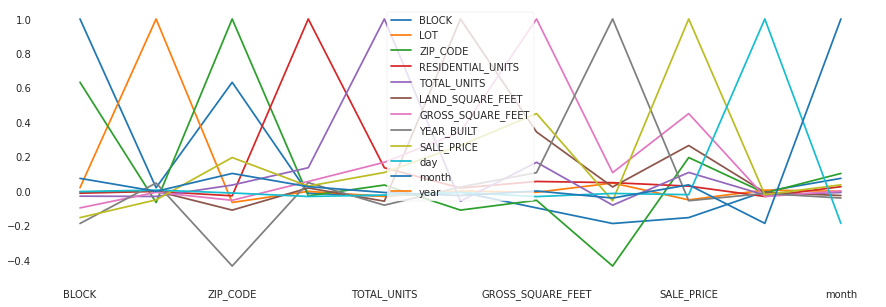

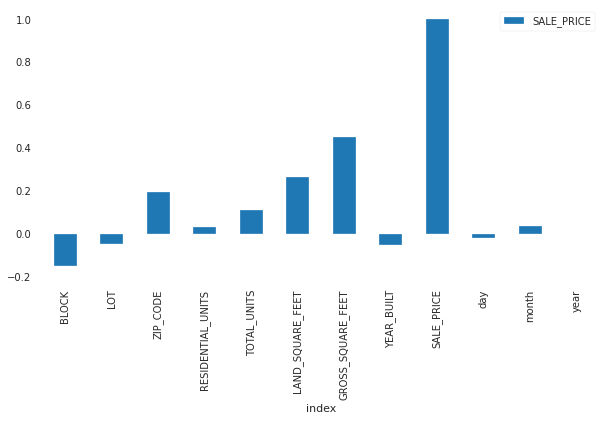

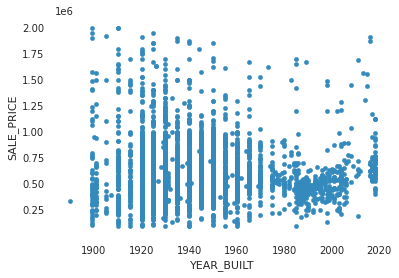

In [512]:
df.corr().plot(figsize=(15,5))

df.corr().reset_index().plot(x='index', y='SALE_PRICE',figsize=(10,5), kind ='bar')
df.plot(x='YEAR_BUILT', y='SALE_PRICE', kind='scatter')

In [513]:
# split test / train per insrt

#bool filters
testm = (df['month'] == 4) 
yr = ( df['year'] == 2019)
trainm = df['month'].isin([1,2,3])

train = df[trainm & yr]
test = df[testm & yr]


target = 'SALE_PRICE'

cats_hc = df[df.describe(exclude='number').columns].describe().loc['unique'] >= 15  # low cardinality will be includd
cats_hc = df.describe(exclude='number').columns[cats_hc].to_list()


print(cats_hc)

features = df.columns.drop([target] + cats_hc)
features

['ADDRESS']


Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'APARTMENT_NUMBER', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'day', 'month', 'year'],
      dtype='object')


 Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
 Do one-hot encoding of categorical features.
 Do feature selection with SelectKBest.

In [514]:
X_train = train[features] #dataframes..
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [515]:

import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# * Do feature selection with *SelectKBest*.


In [516]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.feature_selection import SelectKBest, f_regression

selector =  SelectKBest(score_func=f_regression, k=12)

# .fit_transform on the train set
# .transform on test set

X_train_selected = selector.fit_transform(X_train, y_train)


In [517]:
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)
selected12 = selected_names  


Features selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
BLOCK
BUILDING_CLASS_AT_PRESENT_A3
ZIP_CODE
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A3


Features not selected:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
APARTMENT_NUMBER_nan
APARTMENT_NUMBER_RP.
RESIDENTIAL_UNITS
TOTAL_UNITS
YEAR_BUILT
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A0
BUILDING_CLASS_AT_TIME_OF_SA

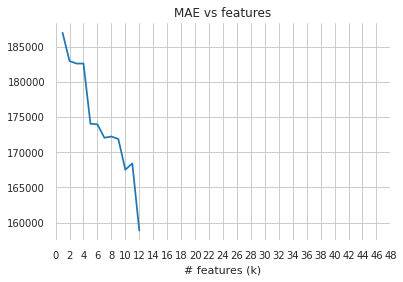

In [520]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

x = []
y= []
for k in range(1, len(X_train.columns) + 1):
  #print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  #print(f'Test MAE: ${mae:,.0f} \n')
  x.append([k])
  y.append([mae])
import matplotlib.pyplot as plt

plt.plot(x,y)
plt.xlabel('# features (k)')
plt.title('MAE vs features')
plt.xticks(range(0,50,2))
plt.grid(True)
plt.show()


### Fit a ridge regression model with multiple features.
 - Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's *fit_transform* method with the train set, and the scaler's *transform()* method with the test set)
### Get mean absolute error for the test set.

In [519]:
from sklearn.linear_model import RidgeCV

X_train = X_train[selected12]   #using 12 features found by kbest
#y_train is already defined #
X_test = X_test[selected12]

alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

ridge = RidgeCV(alphas=[0.01], normalize=True)
ridge.fit(X_train,y_train)
print('the alpha selected by ridgeCV: ',ridge.alpha_)

y_train_pred = ridge.predict(X_train)  
y_test_pred = ridge.predict(X_test)
trainmae = mean_absolute_error(y_train, y_train_pred)
testmae = mean_absolute_error(y_test, y_test_pred)

print('the coefficients for 12 selected features\n', ridge.coef_)
print('\nMean absolute error for the test data and alpha = ',ridge.alpha_, testmae)

the alpha selected by ridgeCV:  0.01
the coefficients for 12 selected features
 [ 8.78549670e+04 -2.74820883e+05 -2.70449975e+05 -3.65253516e+04
  8.72304533e+04  3.08680686e+05 -2.45167584e+01  4.23312015e+04
 -5.61583286e+00  3.31230977e+01  1.77472672e+02  4.23312015e+04]

Mean absolute error for the test data and alpha =  0.01 158710.44607508293
